### 1. Import Packages

In [12]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.impute import KNNImputer

# Librerie per la Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per il Machine Learning
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la curva ROC
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [13]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

SampleType     HealthState SmokingStatus Sex   M1   M2   M3      M4   M5  \
0     Plasma  Adenocarcinoma        Former   F  194  168   77  105985  118   
1     Plasma  Adenocarcinoma        Former   F  215  143  154  100462  133   
2     Plasma  Adenocarcinoma       Current   F  104   67   45   75301   94   
3     Plasma  Adenocarcinoma       Current   M  360  642   82   42097   84   
4     Plasma  Adenocarcinoma       Current   M   96  137   95  112346  168   

      M6  ...  M172  M173  M174  M175   M176  M177  M178  M179  M180  M181  
0  15489  ...   195  1606   300   108   7203    43    59  1009   383    68  
1  13534  ...   184   364  1364   160  11910    82    99   136  1021   165  
2   7390  ...   189   157   884    73   6372    59    35   115   530    72  
3  50943  ...   320  1621   461   104  14011    69    86   845  1309   127  
4  41987  ...    84   769   266   158  18140    40    87  1213  1037   149  

[5 rows x 185 columns]

### 2.1 Data Cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [14]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Eliminiamo le righe con valori nulli all'interno delle colonne "HealthState" e "Sex"
df = df.dropna(subset=["HealthState", "Sex"])

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

# Visualizziamo le prime 5 righe del dataset
df.head()

SampleType     HealthState  SmokingStatus  Sex   M1   M2   M3      M4   M5  \
0     Plasma  Adenocarcinoma              0    1  194  168   77  105985  118   
1     Plasma  Adenocarcinoma              0    1  215  143  154  100462  133   
2     Plasma  Adenocarcinoma              1    1  104   67   45   75301   94   
3     Plasma  Adenocarcinoma              1    0  360  642   82   42097   84   
4     Plasma  Adenocarcinoma              1    0   96  137   95  112346  168   

      M6  ...  M173  M174  M175   M176  M177  M178  M179  M180  M181  Output  
0  15489  ...  1606   300   108   7203    43    59  1009   383    68       1  
1  13534  ...   364  1364   160  11910    82    99   136  1021   165       1  
2   7390  ...   157   884    73   6372    59    35   115   530    72       1  
3  50943  ...  1621   461   104  14011    69    86   845  1309   127       1  
4  41987  ...   769   266   158  18140    40    87  1213  1037   149       1  

[5 rows x 186 columns]

### 3. Extract X & Y

In [15]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

In [16]:
# KNNImputer
imputer_knn = KNNImputer()
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_2010/4178831705.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 3.2 Train-test Split

In [17]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 4. Initial Model Build

In [18]:
# Definiamo il modello Gradient Boosting con gli iperparametri di default
model = GradientBoostingClassifier()

# Addestriamo il modello
model.fit(X_train_knn, y_train_knn)

# Eseguiamo le previsioni sui dati di test
y_pred_knn = model.predict(X_test_knn)

### 5. Initial Model Evalutation

In [19]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.6666666666666666
Precision: 0.625
Recall: 0.8823529411764706
F1-score: 0.7317073170731708
ROC AUC: 0.6599264705882353


Abbiamo un'accuratezza di 63%, una Precision di 60% e una Recall di 82%. Proviamo con la K-Fold Cross Validation.

In [20]:
# Creiamo l'oggetto KFold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

### 6.1 Gradient Boosting Optimization

In [21]:
# Creiamo un nuovo modello Gradient Boosting
model_2 = GradientBoostingClassifier()

# Definiamo la griglia con i parametri da testare
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
}

# Creiamo l'oggetto GridSearchCV
grid_search_model = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=kfolds, n_jobs=-1)
grid_search_model.fit(X_knn, y)

# Visualizziamo i risultati dell'ottimizzazione bayesiana
best_params = grid_search_model.best_params_
print("Iperparametri migliori:", best_params)

Iperparametri migliori: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}


In [22]:
# Utilizziamo gli iperparametri ottimizzati per creare un nuovo modello
best_model = GradientBoostingClassifier(**best_params)
best_model.fit(X_train_knn, y_train_knn)
y_pred_knn = best_model.predict(X_test_knn)

In [23]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.7575757575757576
Precision: 0.7368421052631579
Recall: 0.8235294117647058
F1-score: 0.7777777777777778
ROC AUC: 0.7555147058823529


Proviamo con la K-Fold Cross Validation.

In [24]:
# K-Fold Cross Validation
scores = cross_val_score(best_model, X_knn, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')
print(f'Deviazione standard: {scores.std()}')

Accuratezza media: 0.7801470588235294
Deviazione standard: 0.08552516880000818


### 6.2 KNNImputator Optimization

In [25]:
# Definiamo il range di valori di n_neighbors da testare
n_neighbors_values = np.arange(1, 11)

# Creiamo un oggetto KNNImputer
max_nb = 0 
k_nb = 0

for n_neighbors in n_neighbors_values:

    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_imputed = imputer.fit_transform(X)
    scores = cross_val_score(best_model, X_imputed, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_nb: 
        max_nb = mean
        k_nb = n_neighbors 

    print(f"K={n_neighbors}, Accuratezza Media: {mean}")

print(f"Numero di neighbors ottimale: {k_nb}")
print(f"Accuratezza media ottimale: {max_nb}")

K=1, Accuratezza Media: 0.7669117647058823
K=2, Accuratezza Media: 0.7676470588235295
K=3, Accuratezza Media: 0.7558823529411764
K=4, Accuratezza Media: 0.786764705882353
K=5, Accuratezza Media: 0.7625
K=6, Accuratezza Media: 0.7680147058823529
K=7, Accuratezza Media: 0.7676470588235293
K=8, Accuratezza Media: 0.7621323529411764
K=9, Accuratezza Media: 0.7988970588235293
K=10, Accuratezza Media: 0.7992647058823529
Numero di neighbors ottimale: 10
Accuratezza media ottimale: 0.7992647058823529


In [26]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
imputer_knn = KNNImputer(n_neighbors=k_nb)
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_2010/1569292684.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 7. Feature Selection

In [27]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

K=2, Accuratezza Media: 0.6014705882352941
K=3, Accuratezza Media: 0.5834558823529412
K=4, Accuratezza Media: 0.6088235294117647
K=5, Accuratezza Media: 0.6441176470588236
K=6, Accuratezza Media: 0.6073529411764705
K=7, Accuratezza Media: 0.7117647058823529
K=8, Accuratezza Media: 0.7058823529411764
K=9, Accuratezza Media: 0.7305147058823529
K=10, Accuratezza Media: 0.7316176470588236
K=11, Accuratezza Media: 0.7191176470588235
K=12, Accuratezza Media: 0.7058823529411764
K=13, Accuratezza Media: 0.6753676470588236
K=14, Accuratezza Media: 0.6871323529411765
K=15, Accuratezza Media: 0.70625
K=16, Accuratezza Media: 0.7246323529411764
K=17, Accuratezza Media: 0.7125
K=18, Accuratezza Media: 0.7183823529411765
K=19, Accuratezza Media: 0.6996323529411764
K=20, Accuratezza Media: 0.7422794117647059
K=21, Accuratezza Media: 0.7426470588235294
K=22, Accuratezza Media: 0.7297794117647058
K=23, Accuratezza Media: 0.7121323529411765
K=24, Accuratezza Media: 0.7117647058823529
K=25, Accuratezza M

In [28]:
X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.7988970588235295


In [29]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(k_fs, k_fs))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 9. Results

In [30]:
# Numero ottimale di fold
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# Modello AdaBoost Classifier con gli iperparametri ottimizzati
model = GradientBoostingClassifier(**best_params)

# K-Fold Cross Validation del modello con le features ottimali
y_pred = cross_val_predict(model, X_top, y, cv=kfolds, method='predict_proba')

# Scegliamo na soglia (threshold) per trasformare le probabilità in etichette binarie
threshold = 0.5
y_pred = (y_pred[:, 1] > threshold).astype(int)

# Calcoliamo le metriche
accuracy = metrics.accuracy_score(y, y_pred)
precision = metrics.precision_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
f1 = metrics.f1_score(y, y_pred)
roc_auc = metrics.roc_auc_score(y, y_pred)

In [31]:
# Stampiamo i risultati
print("------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

print("------------------------")
print(f'Matrice di confusione:\n {metrics.confusion_matrix(y, y_pred)}')
print("------------------------")
print(f'Migliori iperparametri:')
for h in best_params:
    print(f'- {h}: {best_params[h]}')
print("------------------------")
print(f'Features selezionate: {len(best_features)}')
print("------------------------")

------------------------
Accuracy: 0.8098
Precision: 0.8165
Recall: 0.8900
F1-score: 0.8517
ROC AUC: 0.7863
------------------------
Matrice di confusione:
 [[43 20]
 [11 89]]
------------------------
Migliori iperparametri:
- learning_rate: 0.2
- max_depth: 5
- min_samples_leaf: 4
- min_samples_split: 2
- n_estimators: 200
- subsample: 0.8
------------------------
Features selezionate: 109
------------------------


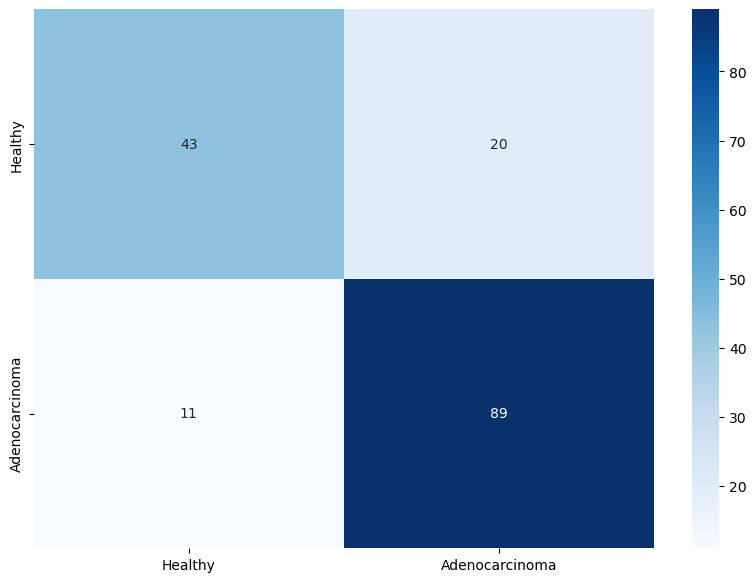

In [32]:
conf_mat = metrics.confusion_matrix(y, y_pred)
classes = ['Healthy', 'Adenocarcinoma']

df_cfm = pd.DataFrame(conf_mat, index=classes, columns=classes)
plt.figure(figsize=(10, 7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues')
plt.show()

### 10. ROC Curve

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

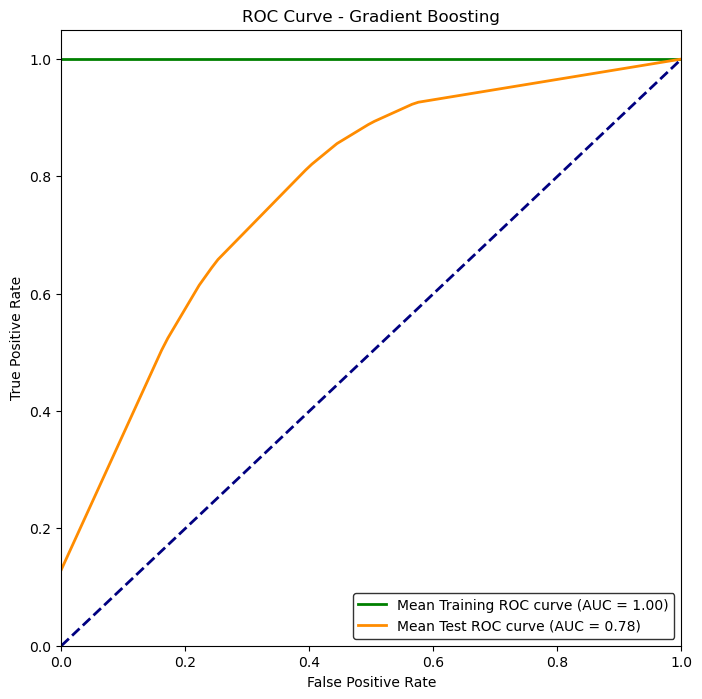

In [34]:
# Inizializziamo le liste per memorizzare i risultati dei singoli fold
all_fpr_train = []
all_tpr_train = []
all_fpr_test = []
all_tpr_test = []

# Eseguiamo la k-fold cross-validation
for train_idx, test_idx in kfolds.split(X_top, y):
    X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Addestriamo il modello sul training set
    model.fit(X_train, y_train)

    # Calcoliamo le probabilità di classe per i dati di training e test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcoliamo la curva ROC per i dati di training
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    all_fpr_train.append(fpr_train)
    all_tpr_train.append(tpr_train)

    # Calcoliamo la curva ROC per i dati di test
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    all_fpr_test.append(fpr_test)
    all_tpr_test.append(tpr_test)

# Calcoliamo le curve ROC medie per i dati di training
mean_fpr_train = np.linspace(0, 1, 100)
mean_tpr_train = np.mean([np.interp(mean_fpr_train, fpr, tpr) for fpr, tpr in zip(all_fpr_train, all_tpr_train)], axis=0)
roc_auc_train = auc(mean_fpr_train, mean_tpr_train)

# Calcoliamo le curve ROC medie per i dati di test
mean_fpr_test = np.linspace(0, 1, 100)
mean_tpr_test = np.mean([np.interp(mean_fpr_test, fpr, tpr) for fpr, tpr in zip(all_fpr_test, all_tpr_test)], axis=0)
roc_auc_test = auc(mean_fpr_test, mean_tpr_test)

# Grafichiamo le curve ROC medie
plt.figure(figsize=(8, 8))
plt.plot(mean_fpr_train, mean_tpr_train, color='green', lw=2, label=f'Mean Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(mean_fpr_test, mean_tpr_test, color='darkorange', lw=2, label=f'Mean Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right", facecolor='white', edgecolor='black')
plt.show()